In [2]:
!pip freeze

absl-py==0.11.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1649013150570/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work
ansiwrap==0.8.4
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1652463872367/work/dist
apache-beam==2.39.0
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1649500320262/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1643313750486/work
asn1crypto @ file:///home/conda/feedstock_root/build_artifacts/asn1crypto_1647369152656/work
astropy @ file:///home/conda/feedstock_root/build_artifacts/astropy_1636583255099/work
astunparse==1.6.3
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-timeout_1640026696943/work
asyncte

In [1]:
## Tenemos que reeconstruir el código del DAG para que se amolde a la estructura del pipeline de prueba

## 1. setup.sh

--env-variables=[NAME=VALUE,…]



A comma-delimited list of environment variable NAME=VALUE pairs to provide to the Airflow scheduler, worker, and webserver processes. NAME may contain upper and lowercase letters, digits, and underscores, but they may not begin with a digit. To include commas as part of a VALUE, see gcloud topics escaping for information about overriding the delimiter.

In [5]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)
REGION = 'us-central1'
print('region: ', REGION)

Project ID:  vertex-playground-352219
region:  us-central1


In [21]:
BQ_NAME = 'chicago_taxi_demos'
PUBSUB_NAME = 'chicago-taxi-pipeline'
BUCKET_NAME = f'{PROJECT_ID}-composer'

print(BQ_NAME)
print(PUBSUB_NAME)
print(BUCKET_NAME)


chicago_taxi_demos
chicago-taxi-pipeline
vertex-playground-352219-composer


In [18]:
!bq mk -d $BQ_NAME

Dataset 'vertex-playground-352219:chicago_taxi_demos' successfully created.


In [20]:
!gcloud pubsub topics create $PUBSUB_NAME

Created topic [projects/vertex-playground-352219/topics/chicago-taxi-pipeline].


In [23]:
BUCKET_NAME

'vertex-playground-352219-composer'

In [25]:
!gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://vertex-playground-352219-composer/...


### 1.1. Creación del Composer

In [6]:
!gcloud composer environments create chicago-demo-environment \
  --location $REGION \
  #--python-version 3 \
  --image-version composer-2.0.20-airflow-2.1.4 

Waiting for [projects/vertex-playground-352219/locations/us-central1/environmen
ts/chicago-demo-environment] to be created with [projects/vertex-playground-352
219/locations/us-central1/operations/49dd2808-90e3-4c30-9e25-f9147d5547f6]...do
ne.


Así pelado, esto
- crea un composer
- crea un bucket de forma automática donde tira el código de airflow monitoring.

Esto se supone que lo que hace es subir ese json al entorno del Composer.

In [8]:
!gcloud composer environments storage data import \
  --source vars.json \
  --environment chicago-demo-environment \
  --location $REGION

Y esto en teoría debería 

In [9]:
!gcloud composer environments run chicago-demo-environment \
  --location $REGION variables \
  -- \
  --i /home/airflow/gcs/data/vars.json

kubeconfig entry generated for us-central1-chicago-demo-en-49dd2808-gke.
W0726 14:28:59.815441   19166 gcp.go:120] WARNING: the gcp auth plugin is deprecated in v1.22+, unavailable in v1.25+; use gcloud instead.
To learn more, consult https://cloud.google.com/blog/products/containers-kubernetes/kubectl-auth-changes-in-gke
W0726 14:29:02.440610   19402 gcp.go:120] WARNING: the gcp auth plugin is deprecated in v1.22+, unavailable in v1.25+; use gcloud instead.
To learn more, consult https://cloud.google.com/blog/products/containers-kubernetes/kubectl-auth-changes-in-gke
Executing within the following Kubernetes cluster namespace: composer-1-19-4-airflow-1-10-15-49dd2808
W0726 14:29:02.764330   19407 gcp.go:120] WARNING: the gcp auth plugin is deprecated in v1.22+, unavailable in v1.25+; use gcloud instead.
To learn more, consult https://cloud.google.com/blog/products/containers-kubernetes/kubectl-auth-changes-in-gke
[2022-07-26 14:29:05,817] {configuration.py:732} INFO - Reading the conf

Se supone que esto debería haber actualizado una variable de entorno, pero no lo hizo:
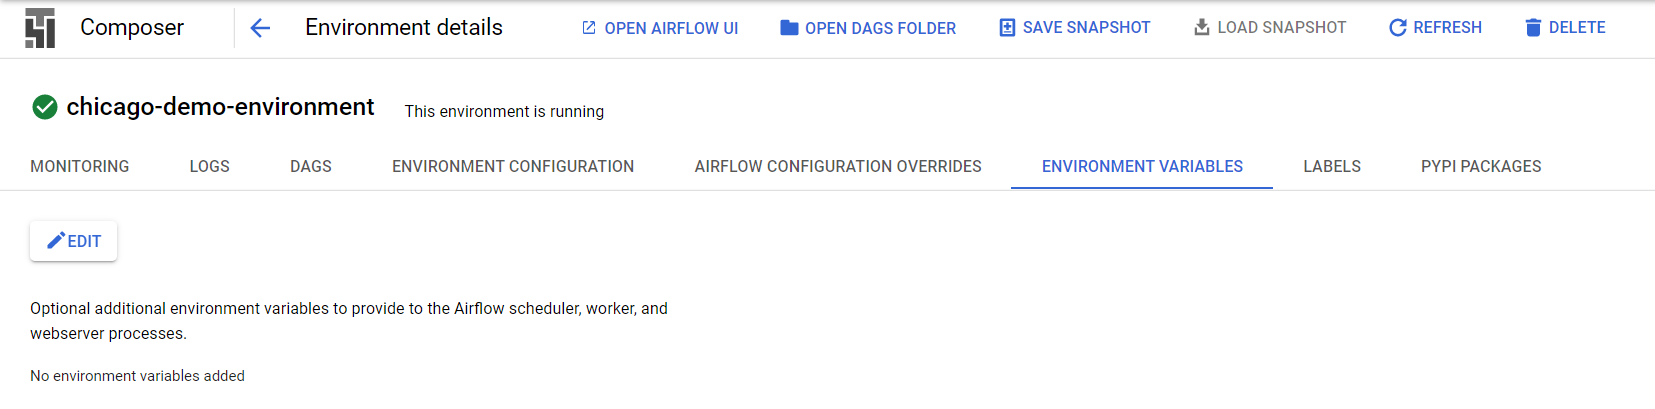

De hecho en el tutorial dicen "si falla, agregalo a mano".

### 1.2 Subir los dags

Hay una forma de ver dónde está la carpeta que está usando Composer:

In [10]:
!gcloud composer environments describe chicago-demo-environment \
   --location $REGION   --format="get(config.dagGcsPrefix)"

gs://us-central1-chicago-demo-en-49dd2808-bucket/dags


Esta parte la pasamos, una vez que termine de reconstruir el DAG de acuerdo a lo que necesito.

## 2. Desarmar el Dag

El setup ahora no lo miro.

### 2.1. Check de data fresca
Primero chequea la data fresca. En la query hay anotación estilo jinja, que refiere a Composer:

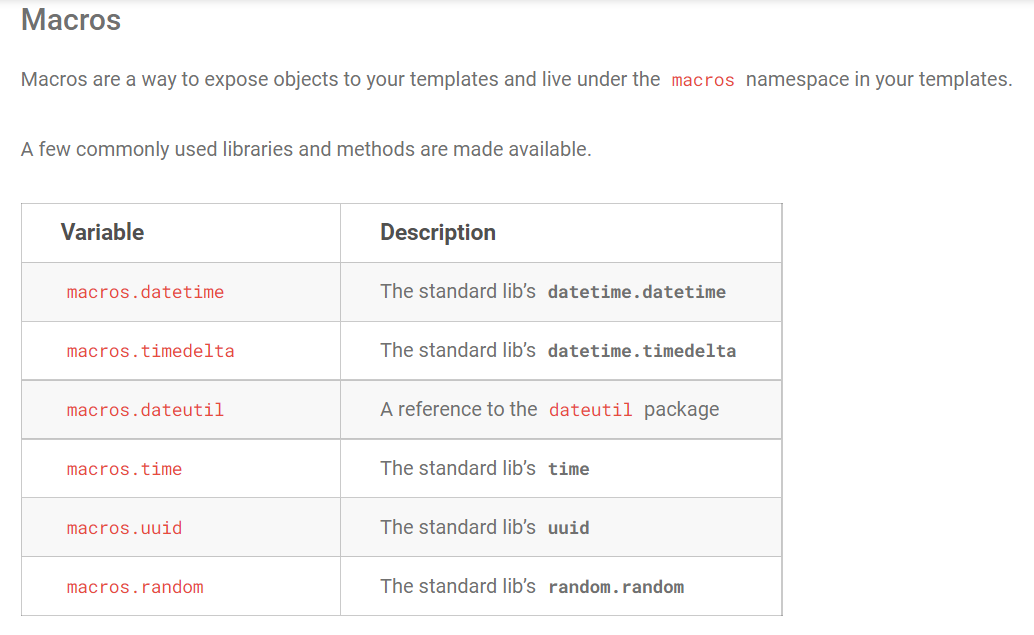
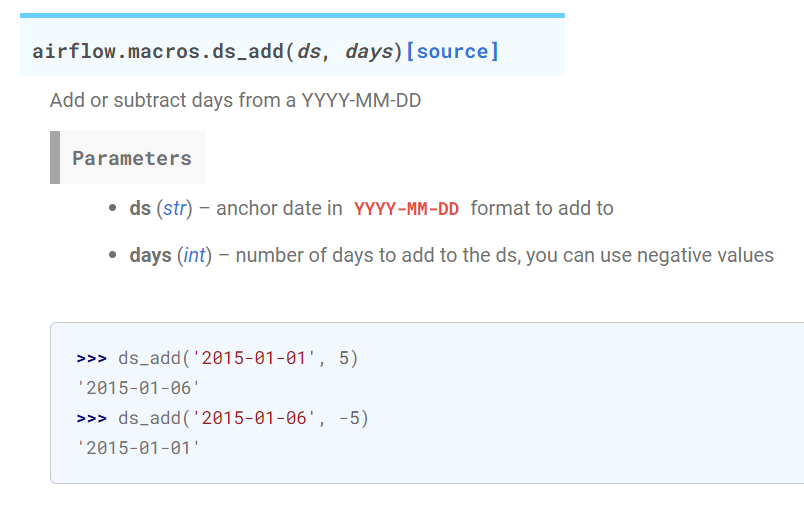

Lo dejo tal y como está, aunque el código en realidad creo que mira los dos meses anteriores.

### 2.2 Pubsub operator
Si todo lo de arriba anda, todo bien, sino manda un mensaje de que falló.

### 2.3. Reemplazar la query inicial
Para probar, es toda la data del 2022. Sin separación por mes.

#### PRUEBA NÚMERO 1
Subimos el código del dag hasta acá, a ver qué pasa.



In [26]:
!gcloud composer environments describe chicago-demo-environment \
   --location $REGION   --format="get(config.dagGcsPrefix)"

gs://us-central1-chicago-demo-en-49dd2808-bucket/dags


In [27]:
!DAGS_FOLDER=$(gcloud composer environments describe chicago-demo-environment \
   --location $REGION   --format="get(config.dagGcsPrefix)")

In [29]:
!gsutil cp ./chicago_taxi_dag.py ${DAGS_FOLDER}/

Copying file://./chicago_taxi_dag.py...
/ [1 files][ 17.0 KiB/ 17.0 KiB]                                                
Operation completed over 1 objects/17.0 KiB.                                     


In [33]:
!gsutil cp chicago_taxi_dag.py $DAGS_FOLDER/

Copying file://chicago_taxi_dag.py...
/ [1 files][ 17.0 KiB/ 17.0 KiB]                                                
Operation completed over 1 objects/17.0 KiB.                                     


In [34]:
!echo $DAGS_FOLDER

Me fui a la terminal para subirlo, después emprolijar.

RESULTADO: **Funcionó**, pero trajo poca data. Seguro es algo de la forma en que se armó el splitting, pero no importa ahora.



### 2.4. Exportar a CSV

Primero usa un BashOperator para borrar la data vieja. Esa es upstream de las que siguen (las que hacen el export).

#### PRUEBA NUMERO 2
Vamos a ver si la conexión BQ - GCS funciona.



In [37]:
train_files = BUCKET_NAME + "/chicago_taxi/data/train/"
train_files

'vertex-playground-352219-composer/chicago_taxi/data/train/'

In [40]:
train_files = f"gs://{BUCKET_NAME}/chicago_taxi/data/train/train.csv"
train_files

'gs://vertex-playground-352219-composer/chicago_taxi/data/train/train.csv'

In [42]:
f'{BUCKET_NAME}/chicago_taxi/data/train/'

'vertex-playground-352219-composer/chicago_taxi/data/train/'

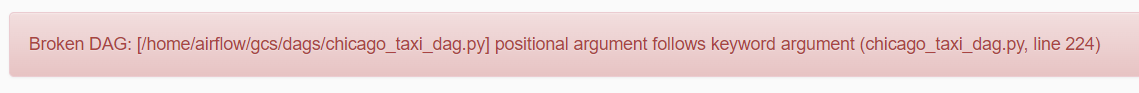

Detalle: nota si hay errores básicos en el código (= por +).

RESULTADO: **funcionó**, atento a la modificación en la forma del filename de train y valid.